In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from netCDF4 import Dataset,num2date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

In [2]:
def reg_2d(x,y):
    """
    x is a one-dimensional vector, e.g. a list of years
    y is a three-dimensional vector with the same leading dimension as x, e.g. gridded temperature field  
    """
    X = np.column_stack([x, np.ones(len(x))])
    Y = y.reshape((len(y),y.shape[-2]*y.shape[-1])) # flatten the lat-lon grid
    reg_coeff = np.linalg.lstsq(X,Y)[0][0].reshape(y.shape[-2],y.shape[-1])
    return reg_coeff   

In [3]:
def make_boundary_path(minlon,maxlon,minlat,maxlat,n=50):
    '''
    return a matplotlib Path whose points are a lon-lat box given by
    the input parameters
    '''
    boundary_path = []
    #North (E->W)
    edge = [np.linspace(minlon,maxlon,n), np.full(n,maxlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #West (N->S)
    edge = [np.full(n,maxlon),np.linspace(maxlat,minlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #South (W->E)
    edge = [np.linspace(maxlon,minlon,n), np.full(n,minlat)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    #East (S->N)
    edge = [np.full(n,minlon),np.linspace(minlat,maxlat,n)]
    boundary_path += [[i,j] for i,j in zip(*edge)]
    boundary_path = mpath.Path(boundary_path)
    return boundary_path

In [4]:
def consecutive(data, stepsize=1):
    return np.array(np.split(data, np.where(np.diff(data) != stepsize)[0]+1))

In [5]:
def block_bootstrap(arr, sample_idxs, N_resamp, lower_percent, upper_percent):
    ## array to store resampled means
    resamp_store = np.full((N_resamp,)+np.shape(arr)[1:],np.nan)
    ## generate the blocks
    blockidxs = consecutive(sample_idxs)
    
    for n in range(N_resamp):
        rand_ints = np.random.randint(0,len(blockidxs),len(blockidxs))
        subsample=np.concatenate(blockidxs[rand_ints])
        resamp_store[n]=np.mean(arr[subsample],axis=0)
    
    lower = np.percentile(resamp_store,q=lower_percent,axis=0)
    upper = np.percentile(resamp_store,q=upper_percent,axis=0)    
    
    sigs = np.sign(lower*upper)
    
    return sigs

In [6]:
# some systems don't have these fonts, but used for the figure in the paper
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Droid Sans']

In [7]:
nregs=5
year1=1979;year2=2022
years=np.arange(year1,year2+1,1)

In [8]:
# regime attribution
f = Dataset('era5_1979_2022_north_american_weather_regimes_w_neutral.nc','r')
time=num2date(f.variables['time'][:],f.variables['time'].units,f.variables['time'].calendar)
daily_regime=f.variables['regime'][:]
f.close()

In [9]:
# 2m temperature
f2 = Dataset('era5_1979_2022_north_american_weather_regime_t2_data.nc','r')
t2 = f2.variables['t_anoms_detrend'][:]
lons = f2.variables['longitude'][:]
lats = f2.variables['latitude'][:]
f2.close()

In [11]:
## composite mean as a function of season
season_months=[[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
regime_mean_season = np.full((len(season_months),nregs,t2.shape[1],t2.shape[2]),np.nan)
sig_means = np.full(np.shape(regime_mean_season),np.nan)

N_boots=10000

for r in range(nregs-1):
    for s in range(len(season_months)):
        print(r,s)
        season_idx = np.where([time[t].month in season_months[s] and daily_regime[t]==r for t in range(len(time))])
        regime_mean_season[s,r] = np.mean(t2[season_idx],axis=0)
        sig_means[s,r] = block_bootstrap(t2,season_idx[0],N_boots,2.5,97.5)

0 0


/tmp/ipykernel_1502391/2800412229.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(np.split(data, np.where(np.diff(data) != stepsize)[0]+1))


0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


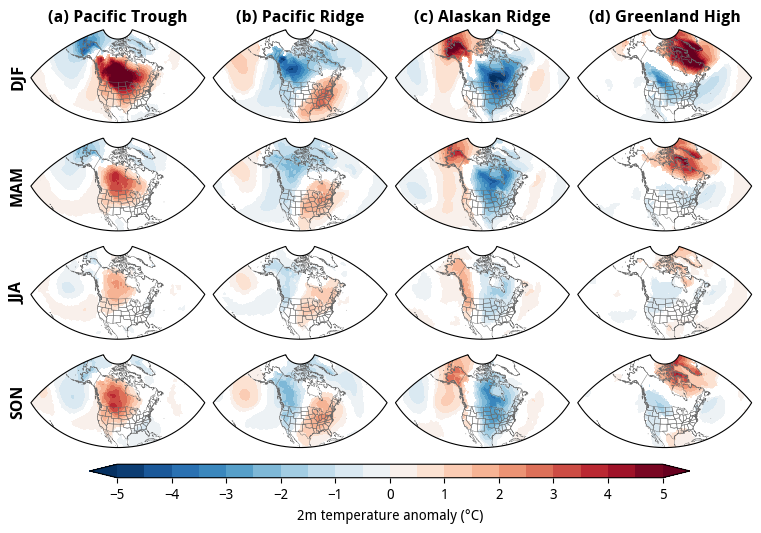

In [12]:
clevs=np.arange(-5,5.5,0.5)
cticks = np.arange(-5,5.5,1)

## specify extent of boundary
extent =[np.min(lons),np.max(lons),np.min(lats),np.max(lats)]
midlon = (extent[0]+extent[1])/2
midlat = (extent[2]+extent[3])/2

fig,axs = plt.subplots(len(season_months),nregs-1,figsize=(7.5,4.5),layout="constrained",subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=midlon, central_latitude=midlat)})
for r in range(nregs-1):   
    for s in range(len(season_months)):
        axs[s,r].set_extent(extent, crs=ccrs.PlateCarree())
        boundary = make_boundary_path(*extent)
        axs[s,r].set_boundary(boundary, transform=ccrs.PlateCarree())
        cf = axs[s,r].contourf(lons,lats,np.ma.masked_where(sig_means[s,r]<0,regime_mean_season[s,r]),cmap='RdBu_r',extend='both',levels=clevs,transform=ccrs.PlateCarree())                                                                  
        axs[s,r].coastlines(color='dimgray',resolution='50m',linewidth=0.3)
        axs[s,r].add_feature(cfeature.STATES, zorder=1, linewidth=0.3, edgecolor='dimgray')

axs[0,0].set_title("(a) Pacific Trough",weight="bold")
axs[0,1].set_title("(b) Pacific Ridge",weight="bold")
axs[0,2].set_title("(c) Alaskan Ridge",weight="bold")
axs[0,3].set_title("(d) Greenland High",weight="bold")

axs[0,0].text(-0.12,0.5,"DJF",rotation=90,transform=axs[0,0].transAxes,weight="bold",fontsize=12,va='center')
axs[1,0].text(-0.12,0.5,"MAM",rotation=90,transform=axs[1,0].transAxes,weight="bold",fontsize=12,va='center')
axs[2,0].text(-0.12,0.5,"JJA",rotation=90,transform=axs[2,0].transAxes,weight="bold",fontsize=12,va='center')
axs[3,0].text(-0.12,0.5,"SON",rotation=90,transform=axs[3,0].transAxes,weight="bold",fontsize=12,va='center')

cb_ax = fig.add_axes([0.112, -0.05, 0.8, 0.03])
cbar = fig.colorbar(cf, cax=cb_ax,orientation="horizontal",ticks=cticks,extend="both",spacing='proportional')
cbar.set_label("2m temperature anomaly (°C)",fontsize=10)
plt.show()